# IBM Applied Data Science Capstone Project
## The Battle of Neighborhoods: Choosing the Best Location for Your Next Food Business
by Inna Nicole Sumalnap

## Introduction

Quezon City is the largest city in the Philippines in terms of population. Quezon City has an area of 16,112.58 hectares, which accounts for one-fourth of the entire Metropolitan Manila. According to the [Quezon City Government Official Website](https://quezoncity.gov.ph/about-the-city-government/economy), there has been an increasing trend in the number of registered businesses from 2008 to 2013. The latest count is at 64,515 with 13,417 as new and 51,098 renewals. More than 90% belongs to the services sector, where hotels & restaurants activities rank 3rd in terms of share.


Quezon City is located on the northeast side of Metro Manila. It is easily accessible from the major highways and mass transit systems, making it a good location for one's food business. The online real estate marketplace [Lamudi](https://www.lamudi.com.ph/journal/10-reasons-why-quezon-city-is-one-of-the-best-places-to-live-in-metro-manila/) even considers Quezon City as a haven for food lovers and bar-hoppers due to a wide variety of restaurants available in the area.

The goal of this project is to help entrepreneurs in their search for possible locations for their food business. It is generally considered that location is one of the most crucial factors to consider when putting up a business. Along with the restaurant's menu, location can make a huge difference in the success of a food business. In an article published by the [Entrepreneur](https://www.entrepreneur.com/article/73784) magazine, Greg Kahn, founder and CEO of Kahn Research Group said that "the best place to be is as close to your biggest competitor as you can be". This means that other restaurants selected their locations based on the favorable aspects of that area. On the other hand, having a concept that is almost indistinguishable to neighboring restaurants also have its drawbacks as highlighted in an article by [EHL Insights](https://hospitalityinsights.ehl.edu/restaurant-management-location). For one, it will be very difficult to win over your neighbors' loyal customers.

The main contribution of this project is to provide entrepreneurs with business location alternatives. Specifically, it seeks to:
- identify the most common restaurant types in each of the neighborhoods in Quezon City
- determine the least popular restaurant types in each location
- cluster similar food establishments in the city
- visualize these clusters on a map
- develop actionable insights and make recommendations about the best location for a food business in Quezon City

## Data

In order to achieve the objectives of this project, the following data were obtained and preprocessed.

1. The list of neighborhoods in Quezon City were collected. It is publicly available on the official website of the [Philippine Statistics Authority](https://psa.gov.ph/sites/default/files/attachments/hsd/pressrelease/NCR.xlsx).
2. The latitude and longitude values of Quezon City were obtained using the geopy library. This was used to create the map of the city.
3. The coordinates of each of the neighborhoods in Quezon City were also obtained using the geopy library. This was used to show the location of the neighborhoods in the map.
4. The number and types of restaurants for each location were collected using the Foursquare API. This will address the first two objectives outlined above.

## Methodology

In this section, the methodology used to analyze the data will be discussed.

In [1]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans

#### Data Collection and Preprocessing

1. The list of barangays was downloaded from the official website of the Philippine Statistics Authority. A **barangay** is a small territorial and administrative district forming the most local level of government in the Philippines. There are 142 barangays in Quezon City.

    Throughout this study, *neighborhood* will be used interchangeably with *barangay*.

In [2]:
file = 'https://psa.gov.ph/sites/default/files/attachments/hsd/pressrelease/NCR.xlsx'
df = pd.read_excel(file, usecols=[1], skiprows=1015, nrows=142)
df.rename(columns={'QUEZON CITY': 'Neighborhood', 'Name': 'Neighborhood'}, inplace = True)
df

,Neighborhood
0,Alicia
1,Amihan
2,Apolonio Samson
3,Aurora
4,Baesa
...,...
137,Payatas
138,Batasan Hills
139,Holy Spirit
140,Greater Lagro


2. The coordinates of Quezon City and its neighborhoods were obtained using the geopy library. The latitude and longitude values was used to create a map visualizing Quezon city and its neighborhoods. This was done using the folium library.

In [3]:
# get the coordinates of quezon city
address = 'Quezon City'

geolocator = Nominatim(user_agent="qc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
(latitude, longitude)

(14.6509905, 121.0486155)

In [4]:
# get the coordinates of neighborhoods
df['Latitude'] = 0
df['Longitude'] = 0

for index, row in df.iterrows():
    l =  row['Neighborhood'] + ', Quezon City'
    # loop until you get the coordinates, maximum number of attempts is 2
    attempt = 0
    while attempt <= 2:
        loc = geolocator.geocode(l, timeout = 1)
        if loc is not None:
            df.loc[index, 'Latitude'] = loc.latitude
            df.loc[index, 'Longitude'] = loc.longitude
        attempt +=1
    print('{}: ({},{})'.format(row['Neighborhood'], loc.latitude, loc.longitude))

Alicia: (14.6616756,121.0249628)
Amihan: (14.632262,121.068538)
Apolonio Samson: (14.654674,121.0094522)
Aurora: (14.6509905,121.0486155)
Baesa: (14.6679416,121.0096837)
Bagbag: (14.6968451,121.0302234)
Bagumbuhay: (14.6247981,121.0659135)
Bagong Lipunan Ng Crame: (14.6117236,121.0512697)
Bagong Pag-asa: (14.6619578,121.0337569)
Bagong Silangan: (14.7119079,121.11161320058503)
Bagumbayan: (14.6063578,121.0818908)
Bahay Toro: (14.6673851,121.028641)
Balingasa: (14.6524765,121.0010734)
Bayanihan: (14.6150965,121.0697597)
Blue Ridge A: (14.619062,121.0731209)
Blue Ridge B: (14.6175315,121.0754222)
Botocan: (14.6364225,121.062373)
Bungad: (14.6492221,121.0237317)
Camp Aguinaldo: (14.6065379,121.06374636542904)
Central: (14.6509905,121.0486155)
Claro: (14.6315563,121.0642117)
Commonwealth: (14.698447,121.0823853)
New Era: (14.6639366,121.0602784)
Kristong Hari: (14.624598,121.03219276881255)
Culiat: (14.6682342,121.0557088)
Damar: (14.6469959,121.0009662)
Damayan: (14.6372964,121.0136818)
D

In [5]:
df.head()

,Neighborhood,Latitude,Longitude
0,Alicia,14.661676,121.024963
1,Amihan,14.632262,121.068538
2,Apolonio Samson,14.654674,121.009452
3,Aurora,14.650991,121.048615
4,Baesa,14.667942,121.009684


In [6]:
# create map of Quezon City and its neighborhoods using latitude and longitude values
map_qc = folium.Map(location=[latitude, longitude], zoom_start=9)

for lat, lng, name in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_qc)
map_qc

3. The resulting map was inspected, and it was observed that the coordinates of one of the neighborhoods were incorrectly assigned. See the marker isolated from the others (lower right). This is Barangay San Roque. In the Philippines, there is a province called Quezon. Filipinos refer to it as Quezon Province to distinguish it from Quezon City. Apparently, a neighborhood called San Roque also exists in Quezon Province. This was then incorrectly picked up by geopy. To rectify this, the coordinates of Barangay San Roque, Quezon City was checked separately. This replaced the incorrect values initially supplied.

In [7]:
# get the coordinates of barangay san roque, quezon city
address_sr = 'Brgy San Roque, Quezon City' # brgy is short for barangay
location_sr = geolocator.geocode(address_sr)
latitude_sr = location_sr.latitude
longitude_sr = location_sr.longitude
(latitude_sr, longitude_sr)

(14.6209772, 121.0610187)

In [8]:
df.loc[df['Neighborhood']=='San Roque', 'Latitude'] = latitude_sr
df.loc[df['Neighborhood']=='San Roque', 'Longitude'] = longitude_sr
df.loc[df['Neighborhood']=='San Roque',:]

,Neighborhood,Latitude,Longitude
101,San Roque,14.620977,121.061019


4. The Foursquare API was used to collect the number and types of establishments in the area.

In [14]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' #'XH0CE4UEMHRJQJLFJNFOQ151ZIK0CEHXISRSEVW0ZS1QGHGW' # your Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B'#'AN2IUFEXIMPR24FISTHH3Z5DNEMWRAU41WUXUHX4MJJBQ5MT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
CATEGORYID = '4d4b7105d754a06374d81259' # food

In [18]:
# create a function that gets all venues in each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORYID)
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [19]:
qc_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])

#### Exploratory Data Analysis

1. The venues collected using the Foursquare API were then grouped by neighborhood. This showed the number of food venues returned for each neighborhood. Notice that there were no venues returned for 2 neighborhoods i.e., a total of 140 out of 142 neighborhoods had information on food venues. Furthermore, 84 different categories of food establishments in the area were noted.

In [20]:
qc_venues_grouped = qc_venues.groupby('Neighborhood').count()[['Venue']]
qc_venues_grouped

,Venue
Neighborhood,
Alicia,4
Amihan,23
Apolonio Samson,7
Aurora,10
Baesa,6
...,...
Veterans Village,20
Villa Maria Clara,34
West Kamias,8


In [21]:
len(qc_venues['Venue Category'].unique())

84

2. The 10 most common restaurant types as well as the 10 least popular restaurant types in Quezon City were also identified.

In [22]:
most_popular = qc_venues['Venue Category'].value_counts().nlargest(10).to_frame()
most_popular

,Venue Category
Fast Food Restaurant,254
Café,231
Filipino Restaurant,222
Chinese Restaurant,199
Bakery,172
BBQ Joint,159
Pizza Place,114
Burger Joint,111
Restaurant,109
Japanese Restaurant,95


In [23]:
least_popular = qc_venues['Venue Category'].value_counts().nsmallest(10).to_frame()
least_popular

,Venue Category
Malay Restaurant,1
Japanese Curry Restaurant,1
Udon Restaurant,1
Taco Place,1
Bagel Shop,1
Molecular Gastronomy Restaurant,1
Peruvian Restaurant,1
German Restaurant,1
Theme Restaurant,1
Pet Café,1


3. The DataFrame with the coordinates of the neighborhoods were merged with the DataFrame showing the number of food venues for each neighborhood. The resulting DataFrame contains the name of the neighborhood, the latitude, the longitude and the number of food venues in that neighborhood. Using this information, a map was created to visualize the area. The size of the markers corresponds to the number of food venues in the neighborhood

In [24]:
df_venue = df.join(qc_venues_grouped, on = 'Neighborhood', how='inner')
df_venue.rename(columns={'Venue': 'No. of Venues'}, inplace=True)
df_venue

,Neighborhood,Latitude,Longitude,No. of Venues
0,Alicia,14.661676,121.024963,4
1,Amihan,14.632262,121.068538,23
2,Apolonio Samson,14.654674,121.009452,7
3,Aurora,14.650991,121.048615,10
4,Baesa,14.667942,121.009684,6
...,...,...,...,...
136,Sangandaan,14.673796,121.020467,4
138,Batasan Hills,14.682151,121.097958,1
139,Holy Spirit,14.684944,121.077214,21
140,Greater Lagro,14.727508,121.066056,3


In [25]:
# create map of Quezon City and its neighborhoods using latitude and longitude values
map_qc = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, name, venue in zip(df_venue['Latitude'], df_venue['Longitude'], df_venue['Neighborhood'],
                                 df_venue['No. of Venues']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.2*venue,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_qc)
map_qc

#### Clustering

The main objective of this project is to help entrepreneurs in their search for the best location for their food business. One way of doing this is to cluster similar food establishments in the area.  K-means clustering, an unsupervised machine learning algorithm, was used in this project. This will be done with the help of the Scikit-learn library.

1. Venue categories, which are categorical variables, were transformed into dummy variables.

In [26]:
# convert categorical variable into dummy/indicator variables
qc_dummy = pd.get_dummies(qc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
qc_dummy['Neighborhood'] = qc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [qc_dummy.columns[-1]] + list(qc_dummy.columns[:-1])
qc_dummy = qc_dummy[fixed_columns]

qc_dummy

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alicia,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Amihan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,North Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2734,North Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2735,North Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2736,North Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2. The rows of the resulting DataFrame were grouped by neighborhood and the mean occurrence of each category was calculated.

In [27]:
qc_grouped = qc_dummy.groupby('Neighborhood').mean().reset_index()
qc_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,...,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alicia,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,Amihan,0.0,0.043478,0.043478,0.0,0.173913,0.0,0.0,0.0,0.130435,...,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.000000,0.000000
2,Apolonio Samson,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,Aurora,0.0,0.000000,0.100000,0.0,0.000000,0.0,0.1,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,Baesa,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Veterans Village,0.0,0.050000,0.050000,0.0,0.100000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.050000
136,Villa Maria Clara,0.0,0.088235,0.117647,0.0,0.088235,0.0,0.0,0.0,0.058824,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.058824
137,West Kamias,0.0,0.000000,0.000000,0.0,0.375000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
138,West Triangle,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [28]:
# remove neighborhood and count columns
qc_grouped_clustering = qc_grouped.drop('Neighborhood', 1)
qc_grouped_clustering

,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,...,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.043478,0.043478,0.0,0.173913,0.0,0.0,0.0,0.130435,0.0,...,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.100000,0.0,0.000000,0.0,0.1,0.0,0.100000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.0,0.050000,0.050000,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.050000
136,0.0,0.088235,0.117647,0.0,0.088235,0.0,0.0,0.0,0.058824,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.058824
137,0.0,0.000000,0.000000,0.0,0.375000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
138,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


5. The optimal number of clusters was determined using the elbow method. Accordingly, six clusters (k=6) were appropriate.

In [29]:
score = []
ss = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(qc_grouped_clustering)
    print('k=' + str(k) + ': ' + str(km.inertia_))
    ss.append(km.inertia_)

k=2: 15.965112086475553
k=3: 14.013278152136952
k=4: 12.791053970968052
k=5: 11.98053645037937
k=6: 11.286273670872259
k=7: 10.865202079012102
k=8: 10.176441863452215
k=9: 9.909543376161926


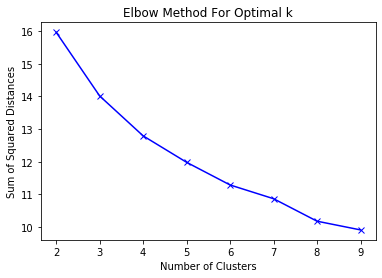

In [30]:
plt.plot(K, ss, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Results and Discussion

The number of clusters was set at six as suggested by the elbow method. The Scikit-learn library was used to cluster the neighborhoods. Subsequently, the clusters were visualized in a map.

In [31]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(qc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 2, 1, 5, 5, 5, 2, 2, 5, 1, 2, 4, 4, 2, 2, 2, 2, 2, 3, 2, 1,
       2, 1, 2, 3, 5, 3, 5, 2, 5, 3, 3, 2, 5, 5, 2, 2, 0, 1, 1, 0, 0, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 5, 3, 3, 2, 2, 2, 5,
       2, 2, 5, 0, 2, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 5, 2, 0, 5, 2, 5, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 1, 1, 3, 1, 5, 1, 5, 5, 2, 1, 2, 1,
       5, 5, 4, 2, 0, 5, 5, 3, 2, 5, 2, 2, 5, 5, 5, 0, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [32]:
# add cluster labels to the main df
df_venue.insert(0, 'Cluster Labels', kmeans.labels_)
df_venue

,Cluster Labels,Neighborhood,Latitude,Longitude,No. of Venues
0,1,Alicia,14.661676,121.024963,4
1,2,Amihan,14.632262,121.068538,23
2,2,Apolonio Samson,14.654674,121.009452,7
3,1,Aurora,14.650991,121.048615,10
4,5,Baesa,14.667942,121.009684,6
...,...,...,...,...,...
136,2,Sangandaan,14.673796,121.020467,4
138,2,Batasan Hills,14.682151,121.097958,1
139,2,Holy Spirit,14.684944,121.077214,21
140,2,Greater Lagro,14.727508,121.066056,3


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# drop rows with NaN cluster
df_cluster = df_venue.dropna(subset=['Cluster Labels'])

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, n, cluster, venue in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Neighborhood'],
                                       df_cluster['Cluster Labels'], df_cluster['No. of Venues']):
    label = folium.Popup(str(n) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.2*venue,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

Before examining each cluster, a new DataFrame that includes the cluster as well as the top 10 venues for each neighborhood was created. This made it easier to check the most common restaurant types in each cluster and in each of the neighborhoods.

In [34]:
# create a function to get the top 10 venues for each neighborhood.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
# create a new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Cluster Labels', 'Latitude', 'Longitude']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[['Neighborhood', 'Cluster Labels', 'Latitude', 'Longitude']] = df_cluster[['Neighborhood', 'Cluster Labels', 'Latitude', 'Longitude']]

for ind in np.arange(qc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 4:] = return_most_common_venues(qc_grouped.iloc[ind, 1:], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alicia,1,14.661676,121.024963,Filipino Restaurant,Fast Food Restaurant,Burger Joint,Wings Joint,Food Truck,Empanada Restaurant,English Restaurant,Fish & Chips Shop,Food,Food Court
1,Amihan,2,14.632262,121.068538,Bakery,Café,Burger Joint,Restaurant,Filipino Restaurant,Asian Restaurant,Pizza Place,Seafood Restaurant,Chinese Restaurant,Food Court
2,Apolonio Samson,2,14.654674,121.009452,Café,Fast Food Restaurant,Bakery,Snack Place,Chinese Restaurant,Food Truck,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food
3,Aurora,1,14.650991,121.048615,Filipino Restaurant,Restaurant,Breakfast Spot,New American Restaurant,Fried Chicken Joint,Burger Joint,Café,Japanese Restaurant,BBQ Joint,Gluten-free Restaurant
4,Baesa,5,14.667942,121.009684,Fast Food Restaurant,Café,Comfort Food Restaurant,Wings Joint,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Sangandaan,2,14.673796,121.020467,Filipino Restaurant,Bakery,Café,Japanese Restaurant,Wings Joint,Seafood Restaurant,BBQ Joint,Donut Shop,Fast Food Restaurant,Fried Chicken Joint
138,Batasan Hills,2,14.682151,121.097958,BBQ Joint,Filipino Restaurant,Asian Restaurant,Restaurant,Bakery,Burger Joint,Café,Middle Eastern Restaurant,Persian Restaurant,Wings Joint
139,Holy Spirit,2,14.684944,121.077214,Bakery,Restaurant,Fast Food Restaurant,Filipino Restaurant,Café,Japanese Restaurant,Greek Restaurant,Food Court,Empanada Restaurant,English Restaurant
140,Greater Lagro,2,14.727508,121.066056,Café,Diner,Fast Food Restaurant,Steakhouse,Chinese Restaurant,Noodle House,Restaurant,Japanese Restaurant,Fried Chicken Joint,Sandwich Place


In [36]:
# create map of cluster 1
def map_cluster(cluster):
    
    map = folium.Map(location=[latitude, longitude], zoom_start=13)

    for lat, lng, name in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood']):
        label = name
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)
    return map

The most common restaurant type among the neighborhoods in Cluster 1 is burger joint.

In [37]:
cluster1 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 0, :]
cluster1

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Escopa IV,0,14.625535,121.074122,Burger Joint,Donut Shop,Food Court,Food Truck,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food
42,Gulod,0,14.712471,121.039199,Café,Noodle House,Burger Joint,Food Truck,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court
43,Horseshoe,0,14.611469,121.041603,Donut Shop,Pizza Place,Diner,Noodle House,Wings Joint,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
70,Obrero,0,14.628510,121.029555,Burger Joint,Steakhouse,Pizza Place,Fast Food Restaurant,Food Court,Food Stand,Empanada Restaurant,English Restaurant,Filipino Restaurant,Fish & Chips Shop
84,Quirino 2-A,0,14.631272,121.058990,Bakery,Diner,Deli / Bodega,Burger Joint,Wings Joint,Food Truck,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food
115,South Triangle,0,14.637982,121.036196,Burger Joint,Donut Shop,Fast Food Restaurant,Bakery,Filipino Restaurant,Breakfast Spot,Tapas Restaurant,Pizza Place,Chinese Restaurant,Food Stand
126,Unang Sigaw,0,14.658897,121.001209,Burger Joint,Café,Donut Shop,Diner,Pizza Place,Gluten-free Restaurant,German Restaurant,English Restaurant,Hot Dog Joint,Fast Food Restaurant


In [38]:
map_cluster(cluster1)

On the other hand, the most common type of restaurant among neighborhoods in Cluster 2 is Filipino restaurant.

In [39]:
cluster2 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 1, :]
cluster2

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alicia,1,14.661676,121.024963,Filipino Restaurant,Fast Food Restaurant,Burger Joint,Wings Joint,Food Truck,Empanada Restaurant,English Restaurant,Fish & Chips Shop,Food,Food Court
3,Aurora,1,14.650991,121.048615,Filipino Restaurant,Restaurant,Breakfast Spot,New American Restaurant,Fried Chicken Joint,Burger Joint,Café,Japanese Restaurant,BBQ Joint,Gluten-free Restaurant
11,Bahay Toro,1,14.667385,121.028641,Filipino Restaurant,Korean Restaurant,Gastropub,Wings Joint,Food Stand,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food
22,New Era,1,14.663937,121.060278,Filipino Restaurant,Restaurant,Breakfast Spot,New American Restaurant,Fried Chicken Joint,Burger Joint,Café,Japanese Restaurant,BBQ Joint,Gluten-free Restaurant
24,Culiat,1,14.668234,121.055709,Restaurant,Breakfast Spot,Chinese Restaurant,Food Stand,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food
40,Fairview,1,14.650991,121.048615,Filipino Restaurant,Donut Shop,Café,Comfort Food Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand
41,N. S. Amoranto (Gintong Silahis),1,14.634002,120.993455,Filipino Restaurant,Restaurant,Breakfast Spot,New American Restaurant,Fried Chicken Joint,Burger Joint,Café,Japanese Restaurant,BBQ Joint,Gluten-free Restaurant
47,Kamuning,1,14.627544,121.039062,Asian Restaurant,BBQ Joint,Filipino Restaurant,Tapas Restaurant,Food Truck,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food
49,Kaunlaran,1,14.617568,121.044783,Filipino Restaurant,Restaurant,Breakfast Spot,Tapas Restaurant,Steakhouse,Japanese Restaurant,German Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
55,Maharlika,1,14.633014,120.996771,Wings Joint,Bakery,Filipino Restaurant,Restaurant,Bagel Shop,Food Truck,English Restaurant,Fast Food Restaurant,BBQ Joint,Fish & Chips Shop


In [40]:
map_cluster(cluster2)

In Cluster 3, the most common restaurant type is cafe.

In [52]:
cluster3 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 2, :]
pd.set_option('display.max_rows', 500)
cluster3

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Amihan,2,14.632262,121.068538,Bakery,Café,Burger Joint,Restaurant,Filipino Restaurant,Asian Restaurant,Pizza Place,Seafood Restaurant,Chinese Restaurant,Food Court
2,Apolonio Samson,2,14.654674,121.009452,Café,Fast Food Restaurant,Bakery,Snack Place,Chinese Restaurant,Food Truck,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food
7,Bagong Lipunan Ng Crame,2,14.611724,121.051270,Diner,Filipino Restaurant,Food Truck,Burger Joint,Seafood Restaurant,Breakfast Spot,Tapas Restaurant,Sushi Restaurant,Fried Chicken Joint,Bakery
8,Bagong Pag-asa,2,14.661958,121.033757,Café,Fast Food Restaurant,Asian Restaurant,Steakhouse,Filipino Restaurant,Fried Chicken Joint,Pizza Place,Bakery,Donut Shop,Breakfast Spot
12,Balingasa,2,14.652477,121.001073,Fried Chicken Joint,Japanese Restaurant,Bakery,Fast Food Restaurant,Food Court,Snack Place,Steakhouse,Sushi Restaurant,Shabu-Shabu Restaurant,Buffet
15,Blue Ridge B,2,14.617532,121.075422,Bakery,Asian Restaurant,BBQ Joint,Café,Filipino Restaurant,Restaurant,Burger Joint,Wings Joint,Middle Eastern Restaurant,Diner
16,Botocan,2,14.636423,121.062373,BBQ Joint,Filipino Restaurant,Burger Joint,Asian Restaurant,Café,Diner,Steakhouse,Restaurant,Sandwich Place,Chinese Restaurant
17,Bungad,2,14.649222,121.023732,BBQ Joint,Filipino Restaurant,Burger Joint,Café,Restaurant,Wings Joint,Sandwich Place,Bakery,Diner,Fast Food Restaurant
18,Camp Aguinaldo,2,14.606538,121.063746,Café,BBQ Joint,Bakery,Asian Restaurant,Soup Place,Food Truck,Mediterranean Restaurant,Mexican Restaurant,Filipino Restaurant,Fast Food Restaurant
19,Central,2,14.650991,121.048615,BBQ Joint,Deli / Bodega,Fried Chicken Joint,Wings Joint,Food Stand,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food


In [42]:
map_cluster(cluster3)

Meanwhile, Chinese restaurants are very common in Cluster 4.

In [43]:
cluster4 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 3, :]
cluster4

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Claro,3,14.631556,121.064212,Fast Food Restaurant,Chinese Restaurant,Burger Joint,Wings Joint,Food Truck,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court
26,Damayan,3,14.637296,121.013682,Chinese Restaurant,Steakhouse,Fried Chicken Joint,Filipino Restaurant,Dumpling Restaurant,Bakery,Greek Restaurant,Hawaiian Restaurant,Empanada Restaurant,English Restaurant
28,Del Monte,3,14.643287,121.014802,Pizza Place,Chinese Restaurant,Burger Joint,Fast Food Restaurant,Food Court,French Restaurant,Restaurant,Café,Fried Chicken Joint,Gastropub
32,Don Manuel,3,14.616437,121.005364,Chinese Restaurant,Filipino Restaurant,Wings Joint,Food Stand,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court
33,Duyan-duyan,3,14.629956,121.066545,Chinese Restaurant,Asian Restaurant,Café,Filipino Restaurant,Fast Food Restaurant,Pizza Place,Donut Shop,Snack Place,Restaurant,Bakery
56,Malaya,3,14.650991,121.048615,Chinese Restaurant,Fast Food Restaurant,Café,Asian Restaurant,Steakhouse,Fried Chicken Joint,Malay Restaurant,Pizza Place,Diner,Snack Place
61,Marilag,3,14.625413,121.068992,Chinese Restaurant,Dumpling Restaurant,Steakhouse,Wings Joint,Restaurant,Bakery,Café,Dim Sum Restaurant,Diner,Fast Food Restaurant
62,Masagana,3,14.618377,121.066877,Chinese Restaurant,Fast Food Restaurant,Filipino Restaurant,Wings Joint,Food Stand,Empanada Restaurant,English Restaurant,Fish & Chips Shop,Food,Food Court
78,Pasong Putik Proper (Pasong Putik),3,14.736664,121.062043,Asian Restaurant,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Food Stand,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court
97,San Isidro,3,14.650991,121.048615,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Café,Korean Restaurant,Bakery,Dumpling Restaurant,Pizza Place,Fried Chicken Joint,Fast Food Restaurant


In [44]:
map_cluster(cluster4)

Neighborhoods in Cluster 5 are identical in terms of their most common venue types i.e., Filipino restaurants followed by Wings Joint.

In [45]:
cluster5 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 4, :]
cluster5

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Bayanihan,4,14.615096,121.069760,Filipino Restaurant,Wings Joint,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand
14,Blue Ridge A,4,14.619062,121.073121,Filipino Restaurant,Wings Joint,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand
113,Silangan,4,14.627384,121.059250,Filipino Restaurant,Wings Joint,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand


In [46]:
map_cluster(cluster5)

In Cluster 6, a lot of fast food restaurants can be found.

In [47]:
cluster6 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == 5, :]
cluster6

,Neighborhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Baesa,5,14.667942,121.009684,Fast Food Restaurant,Café,Comfort Food Restaurant,Wings Joint,English Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand
5,Bagbag,5,14.696845,121.030223,Fast Food Restaurant,Bakery,Food Truck,Korean Restaurant,Comfort Food Restaurant,Soup Place,Food Stand,English Restaurant,Filipino Restaurant,Fish & Chips Shop
6,Bagumbuhay,5,14.624798,121.065913,Fast Food Restaurant,Chinese Restaurant,Wings Joint,Snack Place,Café,German Restaurant,Noodle House,Asian Restaurant,Tapas Restaurant,Doner Restaurant
10,Bagumbayan,5,14.606358,121.081891,Fast Food Restaurant,BBQ Joint,Donut Shop,Fried Chicken Joint,Pizza Place,Noodle House,Shawarma Place,Filipino Restaurant,Gluten-free Restaurant,Fish & Chips Shop
27,Damayang Lagi,5,14.619460,121.018680,Bakery,BBQ Joint,Fast Food Restaurant,Asian Restaurant,Spanish Restaurant,Food Truck,Food Court,Pizza Place,Donut Shop,Burrito Place
29,Dioquino Zobel,5,14.619520,121.064821,Fast Food Restaurant,Bakery,Café,Food Truck,Pizza Place,BBQ Joint,Hawaiian Restaurant,Food Stand,English Restaurant,Filipino Restaurant
31,Doña Josefa,5,14.620038,121.007690,Fast Food Restaurant,Chinese Restaurant,Café,Bakery,Filipino Restaurant,Korean Restaurant,Noodle House,Food Court,Steakhouse,Pizza Place
35,East Kamias,5,14.632427,121.056046,Fast Food Restaurant,Donut Shop,Bakery,Italian Restaurant,Buffet,Chinese Restaurant,Mexican Restaurant,Pet Café,Breakfast Spot,Japanese Restaurant
36,Escopa I,5,14.624238,121.073534,Fast Food Restaurant,Burger Joint,Bakery,Diner,Chinese Restaurant,Café,Thai Restaurant,BBQ Joint,Donut Shop,Steakhouse
60,Mariblo,5,14.635349,121.015696,Fast Food Restaurant,Donut Shop,Pizza Place,Fried Chicken Joint,BBQ Joint,Wings Joint,Food Stand,English Restaurant,Filipino Restaurant,Fish & Chips Shop


In [48]:
map_cluster(cluster6)

## Summary and Conclusion

In conclusion, the results provided in this project may help entrepreneurs select the location of their next food business. Knowledge of the most common types of restaurants in an area will enable them to plan strategically. Careful consideration whether to put up a restaurant in an area where similar restaurants are commonly found is therefore recommended. Close proximity to your competitors has both benefits and drawbacks. As mentioned earlier, one disadvantage is tight competition. It is harder to establish your presence, especially if your competitors are more established and well-known in the industry. In contrast, one benefit that you can take advantage of as mentioned by Greg Kahn in the [Entrepreneur](https://www.entrepreneur.com/article/73784) article is foot traffic. In many cases, your competitors may have already used large portions of their advertising budget towards driving traffic to their locations.

These are some of the factors to consider when choosing the best location for your next food business. Other considerations were not discussed in this report as business administration and marketing are outside the domain expertise of the author. 

In summary, whether an entrepreneur looking to establish a food business in Quezon City believes that the advantages of close proximity to competitors outweigh the disadvantages or not, they could still benefit from the results of this study by being equipped with the knowledge of the most common restaurant types in each of the neighborhoods. For example, if an entrepreneur is planning to put up a burger joint and they believe that close proximity to competitors is beneficial, then they should set-up their restaurant in the neighborhoods in Cluster 1. In short, it is still up to the entrepreneur how they are going to utilize the insights provided by this project.

## References

https://www.lexico.com/definition/barangay

https://foursquare.com/

https://www.ibm.com/developerworks/library/os-foursquare/index.html

https://quezoncity.gov.ph/about-the-city-government/

https://www.lamudi.com.ph/journal/10-reasons-why-quezon-city-is-one-of-the-best-places-to-live-in-metro-manila/

https://www.entrepreneur.com/article/73784

https://hospitalityinsights.ehl.edu/restaurant-management-location

https://stanford.edu/~cpiech/cs221/handouts/kmeans.html